# FIT3182 Assignment Part B

### Eu Jia Xin (30881676)


## Task 2. Data Visualisation
Streaming and Static data visualisation for the climate data.

### Q1 : **Streaming data visualisation**  
a. For the incoming climate data plot the line graph of air temperature against
arrival time. You need to label some interesting points such as maximum
and minimum values

In [1]:
# import statements
from kafka import KafkaConsumer
import datetime as dt
from json import loads
import statistics
import matplotlib.pyplot as plt
import statistics

# for Q2a
import pymongo

# for Q2b
import folium
import datetime
# Q2b also uses pymongo!

# this line is required for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

TOPIC = 'Climate'
WIDTH = 16
HEIGHT = 8

In [2]:
# import statements
from kafka import KafkaConsumer
import datetime as dt
from json import loads
import statistics
import matplotlib.pyplot as plt
import statistics

# this line is required for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(TOPIC,
                                   auto_offset_reset='earliest', # consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as e:
        print('Exception while connecting to Kafka...')
        print(e)
    finally:
        return _consumer

def init_plot():
    try:
        width = WIDTH
        height = HEIGHT
        fig = plt.figure(figsize=(width, height))
        ax1 = fig.add_subplot(221)
        ax1.set_xlabel('Air Temperature (Celcius)')
        ax1.set_ylabel('Arrival Time')
        ax1.set_yticks(list(range(0,35,5)))
        ax1.set_ylim(0,35)
        plt.title('Real-time graph of air temperature against arrival time') # giving figure a title
        
        fig.show()
        fig.canvas.draw()
        
        return fig, ax1
    except Exception as e:
        print(str(e))
        
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        
        for message in consumer:
            message = message.value
            
            date = datetime.datetime.now().strftime("%H:%M:%S")
            temperature = message['air_temperature_celcius']
            x.append(date)
            y.append(temperature)
            
            # we start plotting only when we have 10 data points
            if len(x) >= 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_ylabel('Air Temperature (Celcius)')
                ax.set_xlabel('Arrival Time')
                ax.set_yticks(list(range(0,35,5)))
                ax.set_ylim(0,35)
                ax.tick_params(axis='x', labelrotation=45) # date is too long, need to rotate 
                plt.title('Real-time graph of air temperature against arrival time') # giving figure a title

                # label maximum and minimum points
                y_min = min(y)
                x_min = x[y.index(y_min)]
                
                y_max = max(y)
                x_max = x[y.index(y_max)]
                
                min_coord = (x_min, y_min)
                min_offset = (x_min, y_min-3)
                max_coord = (x_max, y_max)
                max_offset = (x_max, y_max+3)
                # paint on the canvas
                ax.annotate(f"Time: {x_min}\nMinimum temperature = {y_min}", xy=min_coord, xytext=min_offset, color='green')
                ax.annotate(f"Time: {x_max}\nMaximum temperature = {y_max}", xy=max_coord, xytext=max_offset, color='red')
                plt.plot(x_min, y_min, 'g-o')
                plt.plot(x_max, y_max, 'r-o')
                fig.canvas.draw()
                
                x.pop(0)
                y.pop(0)
        
    except Exception as e:
        print('ERROR'+ str(e))



<IPython.core.display.Javascript object>


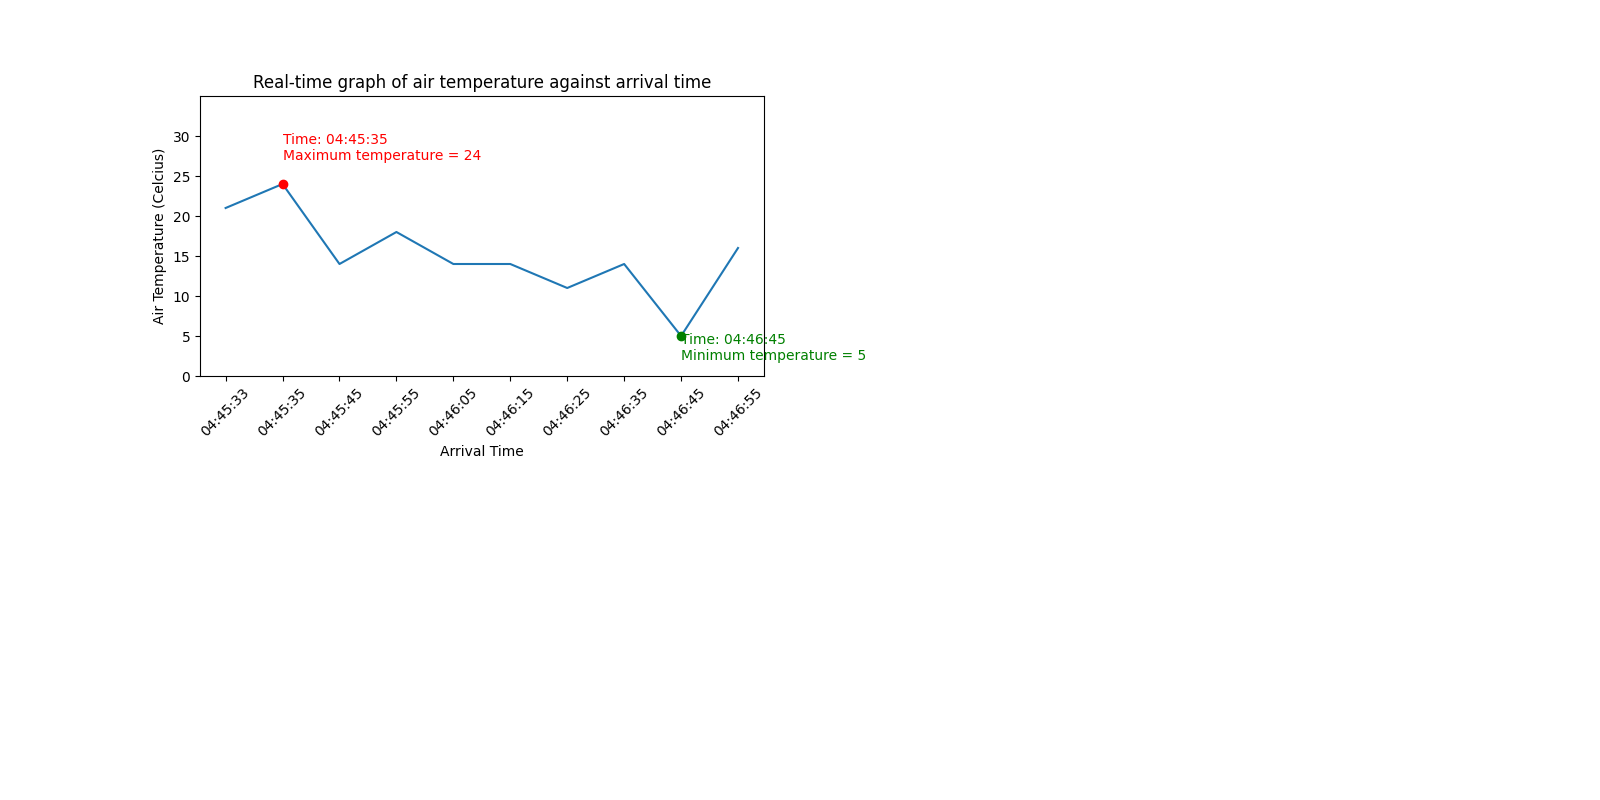

KeyboardInterrupt: 

In [3]:
consumer = connect_kafka_consumer()
fig, ax = init_plot()
consume_messages(consumer, fig, ax)

# NOTE: if running from scratch, may take some time for the graph to collect enough data points. 
# please leave block running until it manages to plot atleast 10 data points on the graph.

Example screenshot of the output:

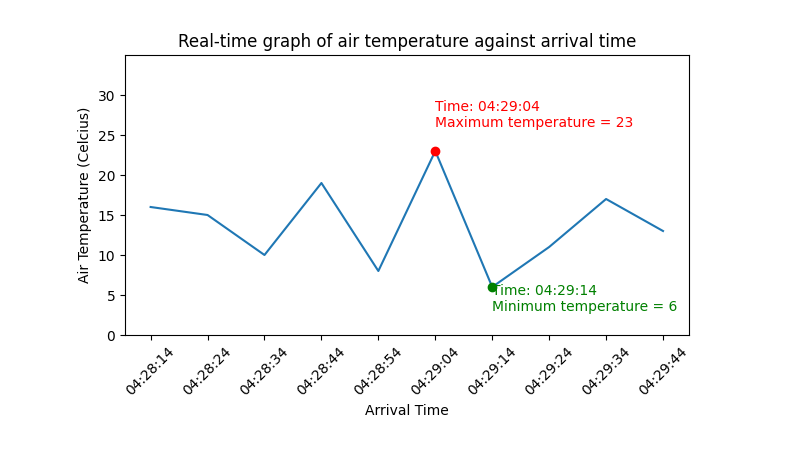

---

### Q2 : **Static data visualization**   

a. Plot a bar chart to visualize the total number of fire records based on each
hour.

<IPython.core.display.Javascript object>


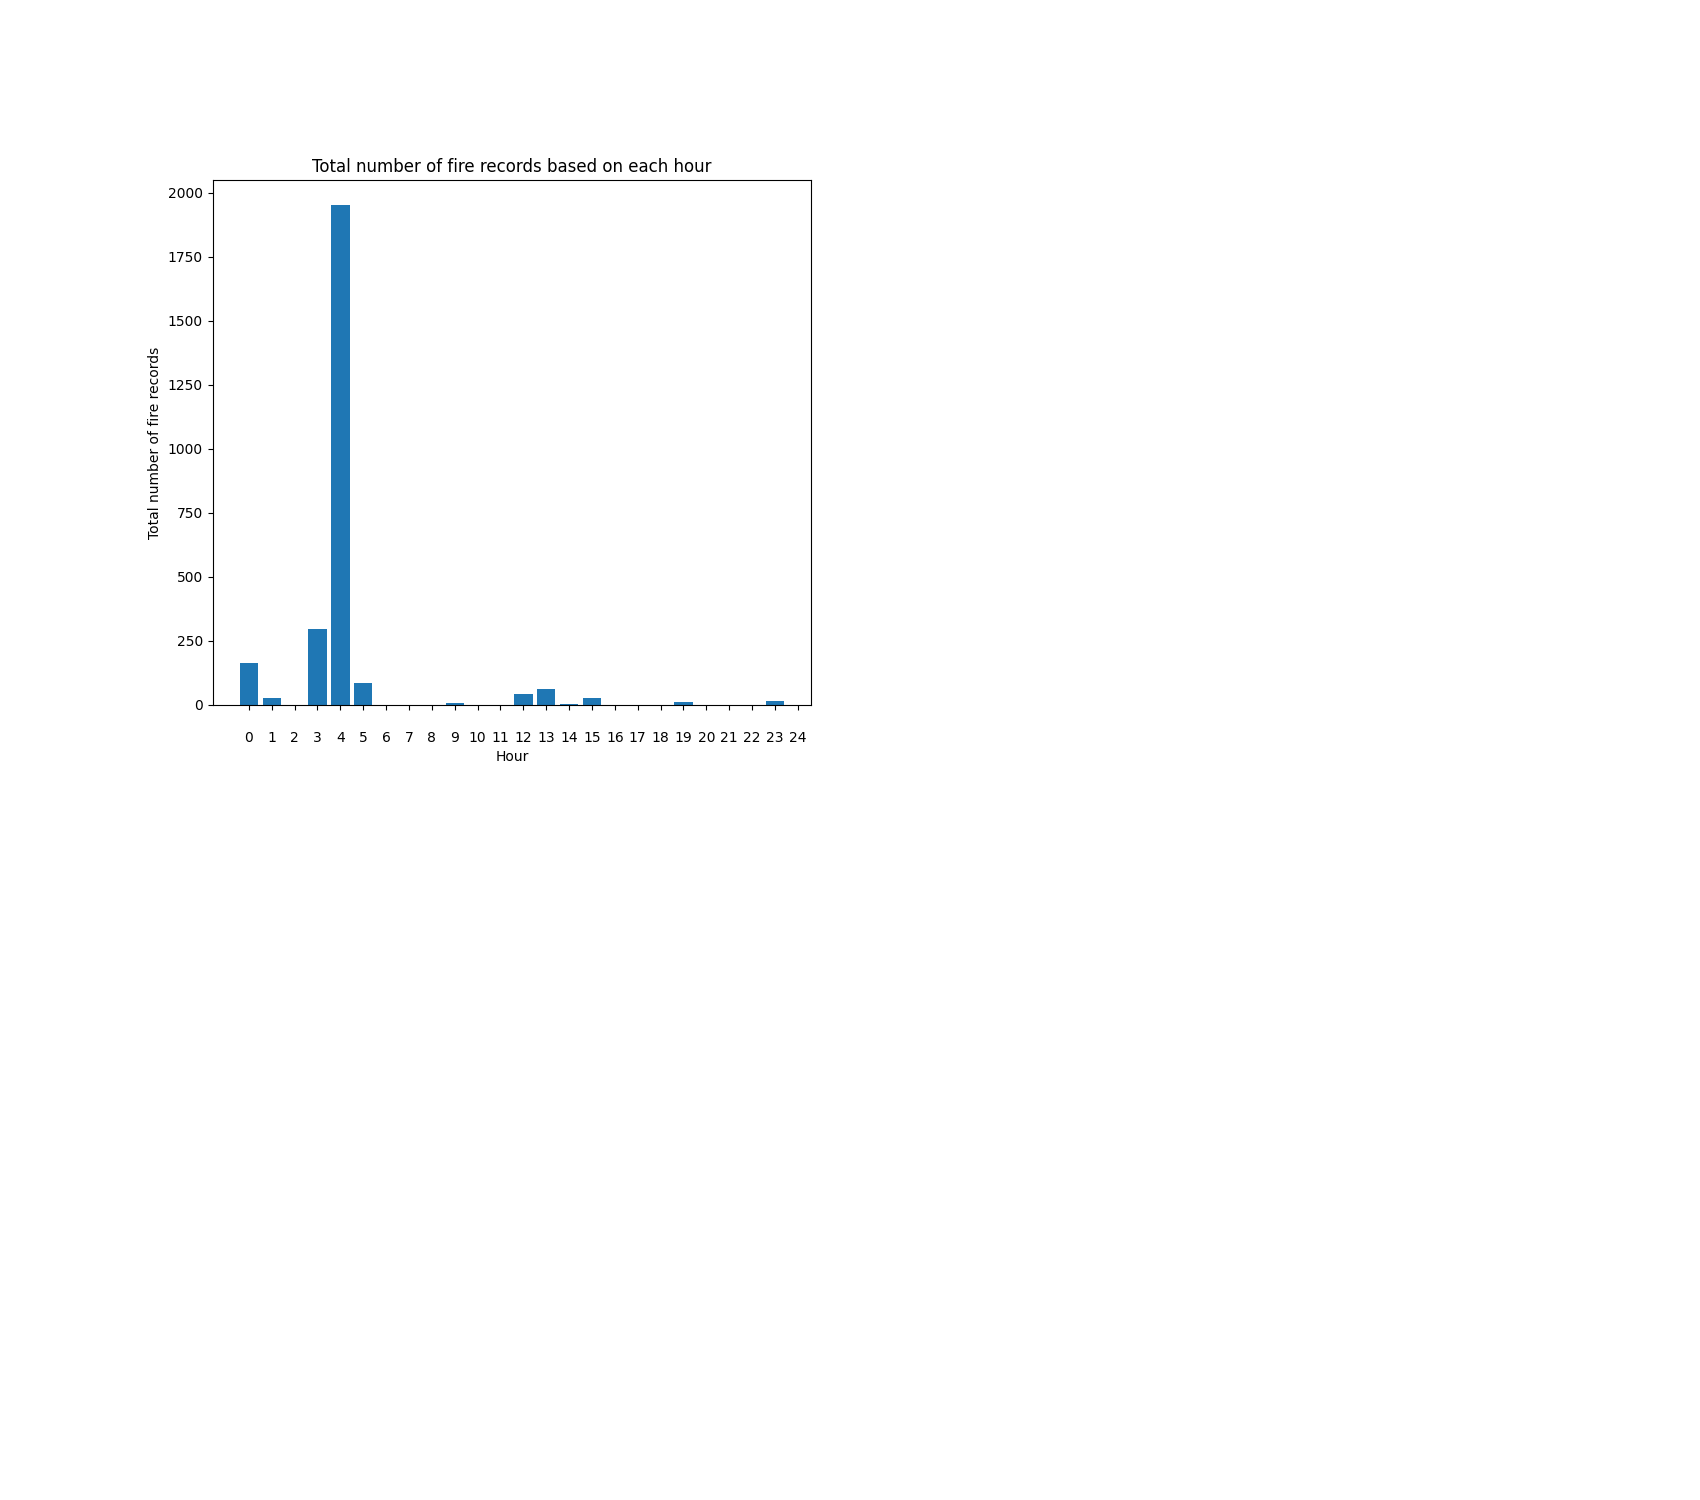

In [4]:
%matplotlib notebook

# get the correct collection from MongoDB
mongo_client = pymongo.MongoClient()
db = mongo_client.fit3182_assignment_db
collection = db.climate

# retrieve all hotspots by flattening the embedded data model
records = collection.aggregate([
    {'$unwind': '$hotspot'},
    {'$project': {'_id': 0, 'hotspot.datetime': 1}}
])

x, y = [], []

# initialise count array for hours
count_arr = [0]*24

# prepare total number of fire records for each hour using the data from MongoDB
for record in records:
    hour = record['hotspot']['datetime'].hour
    count_arr[hour] += 1

# prepare x and y axis
x = list(range(24))
y = count_arr

# Plot bar chart of total no. of fire records for each hour 
fig = plt.figure(figsize=(17,15))
ax = fig.add_subplot(221)
ax.bar(x, y)
ax.set_xlabel('Hour')
plt.xticks(x + [24])
ax.set_ylabel('Total number of fire records')
ax.tick_params(axis="x",pad=15)
plt.title('Total number of fire records based on each hour')

mongo_client.close()

# visualise the data in a bar chart
fig.show()
fig.canvas.draw()

Example screenshot of Q2
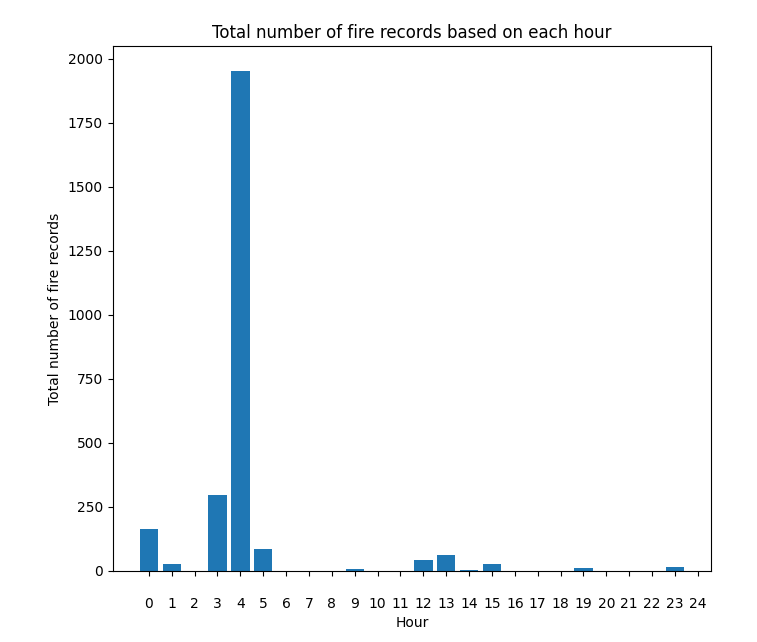

b. In a map visualize fire locations as markers. Use a ‘blue’ marker if the cause
of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed
information such as air temperature, surface temperature, relative humidity,
and confidence with the marker tooltip.

Melbourne coordinates found from https://www.latlong.net/place/melbourne-vic-australia-27235.html is stated as (-37.840935, 144.946457).

In [9]:
melbourne_coord = (-37.840935, 144.946457)

# get map instance
fmap = folium.Map(location=melbourne_coord, zoom_start=8)

mongo_client = pymongo.MongoClient()
db = mongo_client.fit3182_assignment_db
collection = db.climate

# prepare the fire data using data from mongoDB
# only data from 2021-01-01 has 'cause' in hotspot, which is what we need.
records = collection.aggregate([
    {'$unwind': '$hotspot'},
    {
        '$match': {'hotspot.datetime': {'$gte': datetime.datetime(2022, 1, 1)}}
    },
    {'$project':{
            'hotspot.latitude':True, 'hotspot.longitude':True,
            '_id': False, 'air_temperature_celcius': True, 'hotspot.surface_temperature_celcius':True, 
             'relative_humidity': True, 'hotspot.confidence': True, 'hotspot.cause': True
        }
    }])

for record in records:
#     print(record)
    hotspot = record['hotspot']
    
    details = "<br>".join([f"Cause: {hotspot['cause'].capitalize()}", f"Air Temperature: {record['air_temperature_celcius']}°C", f"Surface Temperature: {hotspot['surface_temperature_celcius']}°C",
                          f"Relative Humidity: {record['relative_humidity']}", f"Confidence: {hotspot['confidence']}"])
    
    # Use blue/red marker to label different cause of fire
    if hotspot['cause'] == 'natural':
        color = 'blue'
    elif hotspot['cause'] == 'other':
        color = 'red'
    
    folium.Marker(
            location=(hotspot['latitude'], hotspot['longitude']),
            tooltip=details,
            icon=folium.Icon(color=color, icon='info-sign'),
    ).add_to(fmap)
        
        
fmap

Example screenshot of Q2.2b:
\
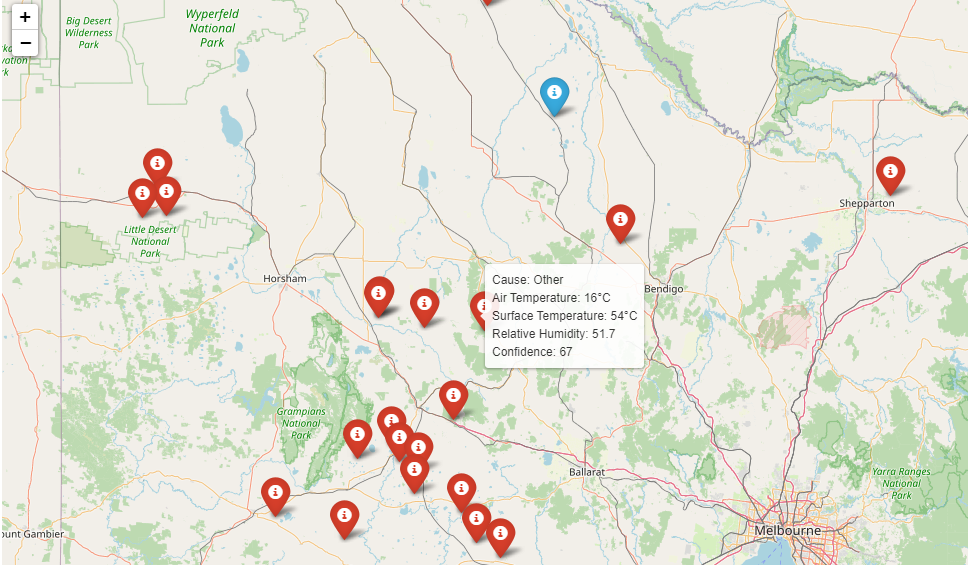